In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
file_2021_path = '2021_data.csv'
file_2023_path = '2023_data.csv'

data_2021 = pd.read_csv(file_2021_path)
data_2023 = pd.read_csv(file_2023_path)

# Drop unnecessary columns and inspect for missing or invalid values
data_2021_cleaned = data_2021.drop(columns=["Unnamed: 0", "Agree", "Age", "Degree", "Sex", "Nationality", "Definition TE", "Covid19 changed", "Further comments"])

# Display cleaned data and missing values summary
data_2021_cleaned.head()

,Clarity of lecture content,Personality of the teacher,Listening to students,"Open minded, engaging, fairness teacher",Good comunicator,Academic support,Teacher's passion for the subject,Small group workshops,Advice for exams,Difficulty of exams,...,Careers support,Learning environment,Didactive passive lecture,"Interactive lecture (discussions, debate...)","Interactive lecture (Polls, Kahoot...)",Research on the subject,Problem based learning,Involving small group work,Challenging content,Requires further reading
0,Extremely useful,Extremely useful,Extremely useful,Extremely useful,Extremely useful,Extremely useful,Extremely useful,Slightly useful,Extremely useful,Extremely useful,...,Neutral,Moderately negative,Bad property,Good property,Best property,Good property,Good property,Bad property,Neutral,Worst property
1,Extremely useful,Very useful,Moderately useful,Very useful,Extremely useful,Very useful,Extremely useful,Slightly useful,Slightly useful,Slightly useful,...,Neutral,Moderately positive,Neutral,Good property,Neutral,Good property,Good property,Neutral,Good property,Neutral
2,Extremely useful,Very useful,Very useful,Very useful,Moderately useful,Very useful,Extremely useful,Slightly useful,Very useful,Moderately useful,...,Highly positive,Highly positive,Bad property,Best property,Best property,Best property,Best property,Best property,Best property,Good property
3,Extremely useful,Moderately useful,Slightly useful,Moderately useful,Very useful,Extremely useful,Very useful,Very useful,Very useful,Moderately useful,...,Neutral,Moderately positive,Bad property,Best property,Good property,Good property,Best property,Good property,Neutral,Neutral
4,Moderately useful,Slightly useful,Moderately useful,Moderately useful,Very useful,Very useful,Moderately useful,Slightly useful,Moderately useful,Moderately useful,...,Neutral,Neutral,Bad property,Neutral,Good property,Good property,Best property,Bad property,Neutral,Worst property


In [81]:
# Mapping Likert scale responses to numeric values for clustering
likert_mapping = {
    "Extremely useful": 5,
    "Very useful": 4,
    "Moderately useful": 3,
    "Slightly useful": 2,
    "Not at all useful": 1,
    "Best property": 5,
    "Good property": 4,
    "Neutral": 3,
    "Bad property": 2,
    "Worst property": 1,
    "Highly positive": 5,
    "Moderately positive": 4,
    "Neutral": 3,
    "Moderately negative": 2,
    "Highly negative": 1
}

# Apply the mapping to numeric values
likert_columns = [
    col for col in data_2021_cleaned.columns if data_2021_cleaned[col].isin(likert_mapping.keys()).any()
]
data_2021_cleaned[likert_columns] = data_2021_cleaned[likert_columns].replace(likert_mapping)

# Drop rows with missing values in Likert-scale columns, as they are key for clustering
data_2021_cluster_ready = data_2021_cleaned.dropna(subset=likert_columns)

# Display summary of the processed data for clustering
data_2021_cluster_ready.info(), data_2021_cluster_ready.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 0 to 44
Data columns (total 46 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Clarity of lecture content                         40 non-null     int64  
 1   Personality of the teacher                         40 non-null     int64  
 2   Listening to students                              40 non-null     int64  
 3   Open minded, engaging, fairness teacher            40 non-null     int64  
 4   Good comunicator                                   40 non-null     int64  
 5   Academic support                                   40 non-null     int64  
 6   Teacher's passion for the subject                  40 non-null     int64  
 7   Small group workshops                              40 non-null     int64  
 8   Advice for exams                                   40 non-null     int64  
 9   Difficulty o

(None,
    Clarity of lecture content  Personality of the teacher  \
 0                           5                           5   
 1                           5                           4   
 2                           5                           4   
 3                           5                           3   
 4                           3                           2   
 
    Listening to students  Open minded, engaging, fairness teacher  \
 0                      5                                        5   
 1                      3                                        4   
 2                      4                                        4   
 3                      2                                        3   
 4                      3                                        3   
 
    Good comunicator  Academic support  Teacher's passion for the subject  \
 0                 5                 5                                  5   
 1                 5                 4     

In [82]:
# Normalize data for clustering
scaler = StandardScaler()
cluster_features_scaled_2021 = scaler.fit_transform(data_2021_cluster_ready[likert_columns])

# Display the shape and first few rows of the normalized dataset
cluster_features_scaled_2021.shape, cluster_features_scaled_2021[:5]

((40, 46),
 array([[ 0.63754981,  1.29099445,  1.48865053,  1.5934968 ,  0.88820536,
          0.79056942,  1.06379577, -0.96398156,  0.89781378,  1.94098992,
          0.12761914, -0.33895108,  1.36217148,  0.31767504,  0.52185358,
          1.22557369,  0.06468462, -2.21980903, -1.16666667, -0.02937367,
          0.60445041, -0.67217168, -0.69388867,  0.29488391, -0.43515327,
         -0.5       ,  0.08043734, -0.53881591, -0.46852129, -0.26211122,
         -0.22941573, -1.46377567, -0.18935832, -1.10707964, -0.34125963,
         -0.31234752, -0.89802651, -2.91499686, -0.71515191,  0.55126277,
          1.50529652,  0.38915203, -0.24889135, -1.30421035, -0.81778585,
         -1.46636681],
        [ 0.63754981,  0.25819889, -1.34687429, -0.04085889,  0.88820536,
         -0.79056942,  1.06379577, -0.96398156, -2.36696359, -1.29399328,
         -1.9142871 , -1.38187746, -0.54964814, -0.83750692, -1.14807787,
          0.08550514,  0.06468462,  0.43070922, -1.16666667,  1.14557332,
    

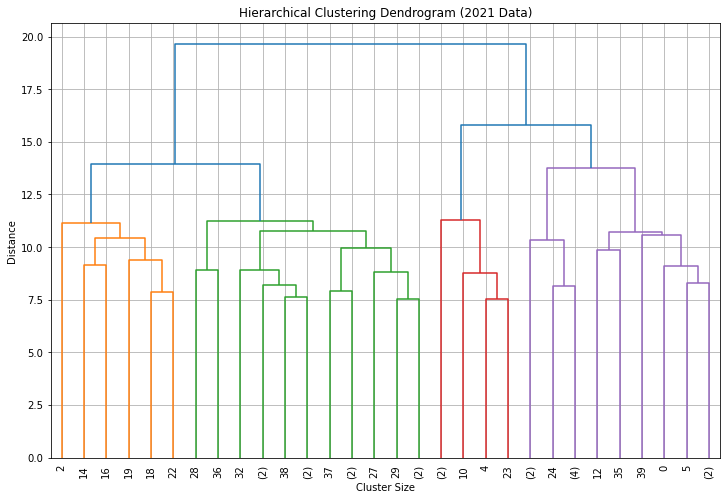

In [83]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Perform hierarchical clustering using Ward's linkage for 2021 data
linkage_2021 = linkage(cluster_features_scaled_2021, method='ward')

# Plot the dendrogram for the 2021 data
plt.figure(figsize=(12, 8))
dendrogram(linkage_2021, truncate_mode='lastp', p=30, leaf_rotation=90, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (2021 Data)')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.grid()
plt.show()

In [84]:
from sklearn.decomposition import PCA

# Reduce dimensions to 2D for visualization using PCA
pca = PCA(n_components=2, random_state=42)
data_2021_2d = pca.fit_transform(cluster_features_scaled_2021)

In [85]:
# Ensure the correct dataset columns match the PCA input
pca_columns = data_2021_cluster_ready.columns[:pca.components_.shape[1]]

# Extract explained variance and feature loadings
explained_variance = pca.explained_variance_ratio_
feature_loadings = pd.DataFrame(
    pca.components_.T,  # Transpose PCA components to align with features
    columns=['PC1', 'PC2'], 
    index=pca_columns  # Use the actual columns that match PCA dimensions
)

# Find the top contributing features for PC1 and PC2
top_features_pc1 = feature_loadings['PC1'].abs().nlargest(20)
top_features_pc2 = feature_loadings['PC2'].abs().nlargest(20)

# Display the results
explained_variance, top_features_pc1, top_features_pc2

(array([0.16257766, 0.09839351]),
 Involving small group work                           0.275366
 Academic support.1                                   0.261632
 Requires further reading                             0.254041
 Team project                                         0.253959
 Promoting critical thinking                          0.241480
 Engagement with postgraduate students                0.233060
 Research seminars                                    0.232214
 Discussion of current news related to the subject    0.214846
 Small group workshops tutorials                      0.211630
 Laboratories                                         0.207459
 Laboratories.1                                       0.194446
 Small group workshops                                0.193997
 Opportunities to meet famous statisticians           0.188701
 Interactive lecture (discussions, debate...)         0.183882
 IT facilities                                        0.171969
 Opportunities to mee

In [86]:
# Extract clusters from the dendrogram with a cutoff for 3 clusters for 2021 data
hierarchical_clusters_2021 = fcluster(linkage_2021, t=3, criterion='maxclust')

# Add 3-cluster hierarchical labels to the dataset
data_2021_cluster_ready['Cluster'] = hierarchical_clusters_2021

<ipython-input-86-6080259cb939>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2021_cluster_ready['Cluster'] = hierarchical_clusters_2021


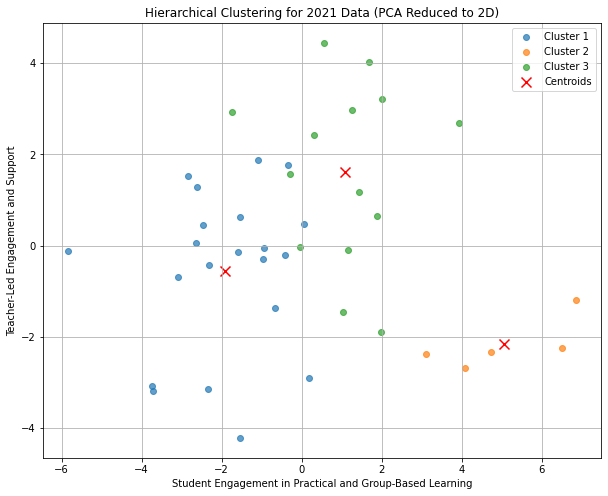

In [87]:
# Calculate cluster centroids in PCA space
centroids = []
for cluster_id in range(1, 4):
    cluster_points = data_2021_2d[hierarchical_clusters_2021 == cluster_id]
    centroids.append(cluster_points.mean(axis=0))
centroids = np.array(centroids)  # Convert to NumPy array for plotting

# Visualize the 3-cluster structure with centroids using PCA
plt.figure(figsize=(10, 8))
for cluster_id in range(1, 4):
    cluster_points = data_2021_2d[hierarchical_clusters_2021 == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}", alpha=0.7)

# Add centroids to the plot
plt.scatter(centroids[:, 0], centroids[:, 1], color='red', marker='x', s=100, label='Centroids')

plt.title('Hierarchical Clustering for 2021 Data (PCA Reduced to 2D)')
plt.xlabel('Student Engagement in Practical and Group-Based Learning')
plt.ylabel('Teacher-Led Engagement and Support')
plt.legend()
plt.grid(True)
plt.show()

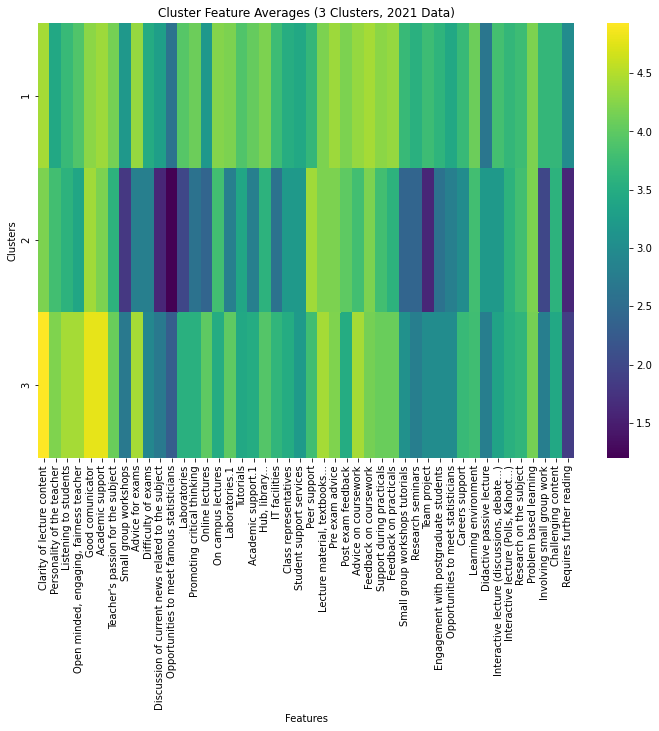

,Clarity of lecture content,Personality of the teacher,Listening to students,"Open minded, engaging, fairness teacher",Good comunicator,Academic support,Teacher's passion for the subject,Small group workshops,Advice for exams,Difficulty of exams,...,Careers support,Learning environment,Didactive passive lecture,"Interactive lecture (discussions, debate...)","Interactive lecture (Polls, Kahoot...)",Research on the subject,Problem based learning,Involving small group work,Challenging content,Requires further reading
Cluster,,,,,,,,,,,,,,,,,,,,,
1,4.428571,3.428571,3.714286,3.904762,4.285714,4.380952,4.142857,3.190476,4.333333,3.476190,...,3.714286,4.095238,2.666667,3.809524,3.666667,3.761905,4.190476,3.666667,3.666667,3.000000
2,4.200000,3.800000,3.600000,3.400000,4.400000,4.200000,3.600000,1.800000,2.800000,2.800000,...,3.000000,3.800000,3.200000,3.200000,3.600000,3.800000,4.200000,2.000000,3.600000,1.600000
3,4.928571,4.214286,4.428571,4.428571,4.785714,4.785714,4.071429,2.714286,4.428571,2.928571,...,3.714286,3.785714,2.785714,3.357143,3.571429,3.642857,4.142857,2.785714,3.428571,1.857143


In [88]:
# Summarize clusters by calculating the mean of each feature
cluster_summary_2021 = data_2021_cluster_ready.groupby('Cluster').mean()

# Visualize the cluster summary as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_summary_2021, cmap="viridis", annot=False, cbar=True)
plt.title("Cluster Feature Averages (3 Clusters, 2021 Data)")
plt.xlabel("Features")
plt.ylabel("Clusters")
plt.show()

# Display the cluster summary for interpretation
cluster_summary_2021

In [111]:
# Verify the cluster distribution directly from the data
students_per_cluster_2021 = data_2021_cluster_ready['Cluster'].value_counts()

# Recalculate 1-based indices for students in each cluster
students_in_clusters_2021 = {
    cluster_id: (data_2021_cluster_ready[data_2021_cluster_ready['Cluster'] == cluster_id].index + 1).tolist()
    for cluster_id in range(1, 4)
}

students_per_cluster_2021, students_in_clusters_2021

(1    21
 3    14
 2     5
 Name: Cluster, dtype: int64,
 {1: [3,
   4,
   7,
   13,
   15,
   17,
   19,
   20,
   21,
   22,
   25,
   30,
   31,
   33,
   35,
   36,
   37,
   38,
   41,
   42,
   44],
  2: [2, 5, 12, 18, 26],
  3: [1, 6, 8, 9, 11, 14, 23, 24, 27, 28, 29, 34, 40, 45]})

In [6]:
# Remove blank rows and unnecessary columns
data_2023_cleaned = data_2023.dropna(how='all')  # Remove the first row as it is blank
data_2023_cleaned = data_2023_cleaned.drop(columns=data_2023_cleaned.columns[[0, 1, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]])

# Identify and remove rows with invalid text (e.g., {"ImportId":})
data_2023_cleaned = data_2023_cleaned[~data_2023_cleaned.apply(lambda x: x.astype(str).str.contains('\{"ImportId":').any(), axis=1)]

# Display cleaned data and missing values summary
data_2023_cleaned.head()

<>:6: SyntaxWarning: invalid escape sequence '\{'
<>:6: SyntaxWarning: invalid escape sequence '\{'
C:\Users\Haoyu\AppData\Local\Temp\ipykernel_14804\1902988199.py:6: SyntaxWarning: invalid escape sequence '\{'
  data_2023_cleaned = data_2023_cleaned[~data_2023_cleaned.apply(lambda x: x.astype(str).str.contains('\{"ImportId":').any(), axis=1)]


,How would you rate the following in terms of Teaching Excellence? - Clarity of lecture content,How would you rate the following in terms of Teaching Excellence? - Personality of the lecturer,How would you rate the following in terms of Teaching Excellence? - Academic support from lecturers,How would you rate the following in terms of Teaching Excellence? - Advice for coursework or exams,How would you rate the following in terms of Teaching Excellence? - Presence of pre-practicals,How would you rate the following in terms of Teaching Excellence? - Feedback after coursework or exams,How would you rate the following in terms of Teaching Excellence? - Inclusion and discussion of relevant research,How would you rate the following in terms of Teaching Excellence? - Includes team projects [group work],How would you rate the following in terms of Teaching Excellence? - Includes Problem-Based Learning [PBL],How would you rate the following in terms of Teaching Excellence? - Diffculty of Exams,...,"What impact do the following have on your ""Student Experience""? - Pre-exam advice","What impact do the following have on your ""Student Experience""? - Post-exam feedback","What impact do the following have on your ""Student Experience""? - Advice/Feedback on coursework","What impact do the following have on your ""Student Experience""? - Pre-practicals","What impact do the following have on your ""Student Experience""? - Support during practicals","What impact do the following have on your ""Student Experience""? - Research seminars","What impact do the following have on your ""Student Experience""? - Team projects [group work]","What impact do the following have on your ""Student Experience""? - Campus environment","What impact do the following have on your ""Student Experience""? - Opportunity to meet scientists and employers","What impact do the following have on your ""Student Experience""? - Small-group tutorials"
2,Essential,Essential,Essential,Important,Neutral,Important,Not so important,Neutral,Neutral,Important,...,Important,Important,Important,Neutral,Important,Irrelevant,Neutral,Important,Neutral,Neutral
3,Important,Important,Essential,Essential,Neutral,Essential,Important,Neutral,Important,Neutral,...,Essential,Essential,Essential,Neutral,Important,Neutral,Neutral,Important,Important,Neutral
4,Essential,Important,Important,Important,Important,Important,Important,Not so important,Neutral,Important,...,Essential,Essential,Essential,Important,Important,Neutral,Important,Important,Important,Essential
5,Important,Important,Not so important,Important,Not so important,Important,Important,Neutral,Important,Essential,...,Essential,Important,Essential,Not so important,Important,Not so important,Not so important,Not so important,Not so important,Important
6,Essential,Important,Essential,Important,Essential,Important,Important,Neutral,Essential,Irrelevant,...,Essential,Important,Essential,Essential,Essential,Neutral,Not so important,Essential,Neutral,Essential


In [8]:
# Define mapping for Likert-scale responses to numerical values
likert_mapping = {
    "Essential": 5,
    "Important": 4,
    "Neutral": 3,
    "Not so important": 2,
    "Irrelevant": 1,
}

# Identify and map Likert-scale columns
likert_columns = [
    col
    for col in data_2023_cleaned.columns
    if "How would you rate" in col or "What impact do the following" in col
]
data_2023_cleaned[likert_columns] = data_2023_cleaned[likert_columns].replace(likert_mapping)

# Convert all data to numeric and handle missing values by imputing the median
data_2023_numeric = data_2023_cleaned.apply(pd.to_numeric, errors="coerce")
data_2023_imputed = data_2023_numeric.fillna(data_2023_numeric.median())

# Display summary of the processed data for clustering
data_2023_imputed.info(), data_2023_imputed.head()

<class 'pandas.core.frame.DataFrame'>
Index: 52 entries, 2 to 75
Data columns (total 36 columns):
 #   Column                                                                                                                Non-Null Count  Dtype  
---  ------                                                                                                                --------------  -----  
 0   How would you rate the following in terms of Teaching Excellence? - Clarity of lecture content                        52 non-null     int64  
 1   How would you rate the following in terms of Teaching Excellence? - Personality of the lecturer                       52 non-null     int64  
 2   How would you rate the following in terms of Teaching Excellence? - Academic support from lecturers                   52 non-null     int64  
 3   How would you rate the following in terms of Teaching Excellence? - Advice for coursework or exams                    52 non-null     int64  
 4   How would you r

C:\Users\Haoyu\AppData\Local\Temp\ipykernel_14804\2582803307.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_2023_cleaned[likert_columns] = data_2023_cleaned[likert_columns].replace(likert_mapping)


(None,
    How would you rate the following in terms of Teaching Excellence? - Clarity of lecture content  \
 2                                                  5                                                
 3                                                  4                                                
 4                                                  5                                                
 5                                                  4                                                
 6                                                  5                                                
 
    How would you rate the following in terms of Teaching Excellence? - Personality of the lecturer  \
 2                                                  5                                                 
 3                                                  4                                                 
 4                                                  4                 

In [10]:
# Normalize data for clustering
scaler = StandardScaler()
cluster_features_scaled_2023 = scaler.fit_transform(data_2023_cleaned[likert_columns])

# Display the shape and first few rows of the normalized dataset
cluster_features_scaled_2023.shape, cluster_features_scaled_2023[:5]

((52, 36),
 array([[ 0.55513611,  1.08420948,  1.02890769, -0.82717019, -0.40628352,
         -0.86154979, -1.48014506,  0.03225806, -0.86386843,  0.64751827,
         -1.96113146, -1.59211933,  0.59319959,  0.40565621,  0.04389513,
         -0.99896104, -0.08707548,  0.0955637 ,  0.17144714, -0.33183182,
         -1.44009793, -0.26568447, -0.07492979,  0.71557426,  0.61916557,
          0.38579426, -0.67269158, -0.3188964 , -0.46291005, -0.39801488,
          0.08349455, -1.96946864,  0.05217589,  0.11051579, -0.24070711,
         -0.42144975],
        [-1.50679801, -0.09035079,  1.02890769,  0.82717019, -0.40628352,
          1.00514142,  1.22047049,  0.03225806,  0.25916053, -0.23855936,
          0.33812611, -0.51692186, -0.40184489, -0.40565621,  0.04389513,
         -0.99896104, -1.59638387,  0.0955637 ,  0.17144714,  0.90068638,
         -0.5220355 ,  0.88561489, -0.07492979, -1.01511698,  1.48934421,
          0.38579426,  1.27063966,  1.06298801,  1.11098412, -0.39801488,
    

In [12]:
# Check for non-finite values in the scaled data
non_finite_check = ~np.isfinite(cluster_features_scaled_2023)
non_finite_rows = np.any(non_finite_check, axis=1)

# If there are non-finite values, handle them
if np.any(non_finite_rows):
    # Replace non-finite values with 0 (or other imputation strategies can be applied)
    cluster_features_scaled_2023[non_finite_rows] = 0

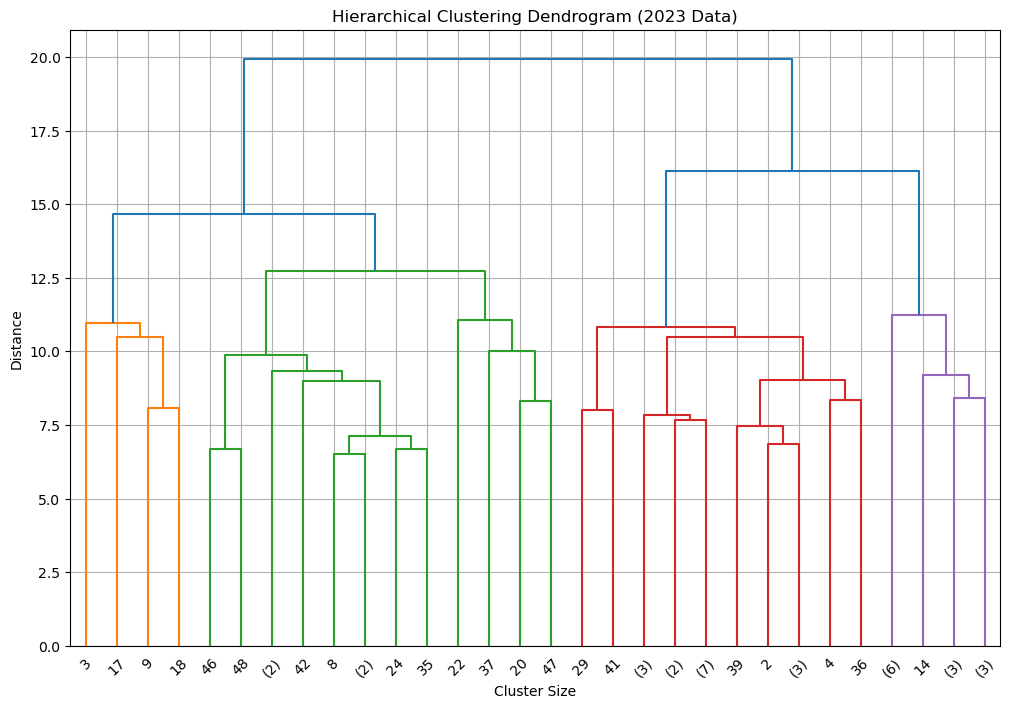

In [14]:
# Compute the linkage matrix using 'ward' method
linkage_2023 = linkage(cluster_features_scaled_2023, method='ward')

# Plot the dendrogram for the 2023 data
plt.figure(figsize=(12, 8))
dendrogram(linkage_2023, truncate_mode='lastp', p=30, leaf_rotation=45, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (2023 Data)')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

In [16]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_2d_2023 = pca.fit_transform(cluster_features_scaled_2023)

In [18]:
# Ensure the correct dataset columns match the PCA input
pca_columns_23 = data_2023_imputed.columns[:pca.components_.shape[1]]

# Extract explained variance and feature loadings
explained_variance = pca.explained_variance_ratio_
feature_loadings = pd.DataFrame(
    pca.components_.T,  # Transpose PCA components to align with features
    columns=['PC1', 'PC2'], 
    index=pca_columns_23  # Use the actual columns that match PCA dimensions
)

# Find the top contributing features for PC1 and PC2
top_features_pc1_23 = feature_loadings['PC1'].abs().nlargest(20)
top_features_pc2_23 = feature_loadings['PC2'].abs().nlargest(20)

# Display the results
explained_variance, top_features_pc1_23, top_features_pc2_23

(array([0.18054619, 0.12010126]),
 How would you rate the following in terms of Teaching Excellence? - Academic support from lecturers                  0.303720
 How would you rate the following in terms of Teaching Excellence? - Use of Technology during lectures                0.299255
 What impact do the following have on your "Student Experience"? - Laboratory facilities                              0.272897
 What impact do the following have on your "Student Experience"? - Lecture facilities                                 0.270538
 How would you rate the following in terms of Teaching Excellence? - Personality of the lecturer                      0.268931
 What impact do the following have on your "Student Experience"? - Academic support from lecturers                    0.267437
 How would you rate the following in terms of Teaching Excellence? - Diffculty of Exams                               0.242001
 How would you rate the following in terms of Teaching Excellence? - Presence

In [20]:
# Cut the dendrogram into 3 clusters
cluster_labels_2023 = fcluster(linkage_2023, 3, criterion='maxclust')

data_2023_cleaned['Cluster'] = cluster_labels_2023

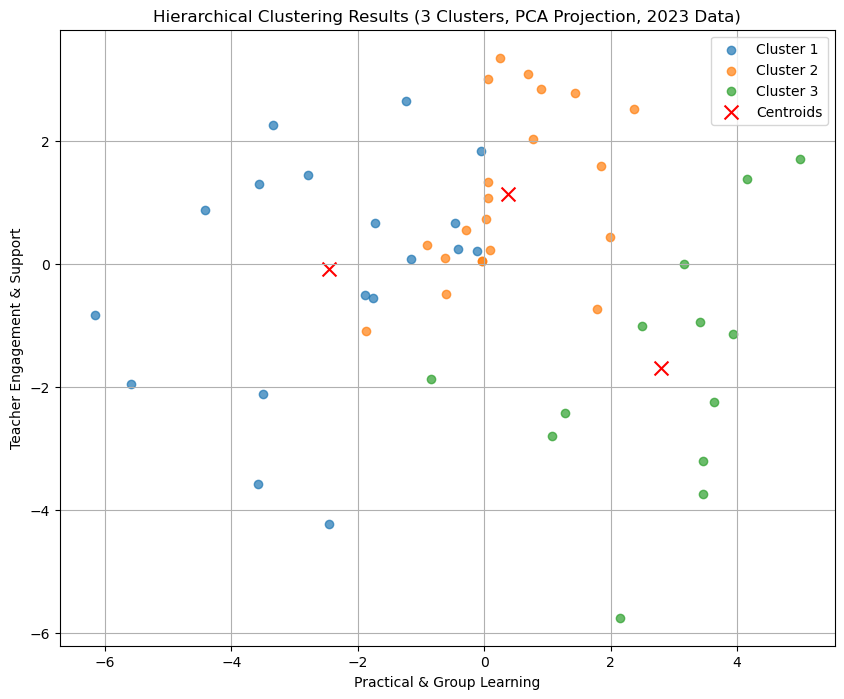

In [34]:
# Calculate cluster centroids in PCA space
centroids_2023 = []
for cluster_id in range(1, 4):
    cluster_points = pca_2d_2023[cluster_labels_2023 == cluster_id]
    centroids_2023.append(cluster_points.mean(axis=0))
centroids_2023 = np.array(centroids_2023)

# Plot the PCA projection with cluster labels and centroids
plt.figure(figsize=(10, 8))
for cluster_id in range(1, 4):
    cluster_points = pca_2d_2023[cluster_labels_2023 == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}", alpha=0.7)

# Add centroids to the plot
plt.scatter(centroids_2023[:, 0], centroids_2023[:, 1], color='red', marker='x', s=100, label='Centroids')

# Rename PCA components for clarity
plt.title("Hierarchical Clustering Results (3 Clusters, PCA Projection, 2023 Data)")
plt.xlabel("Practical & Group Learning")
plt.ylabel("Teacher Engagement & Support")
plt.legend()
plt.grid(True)
plt.show()

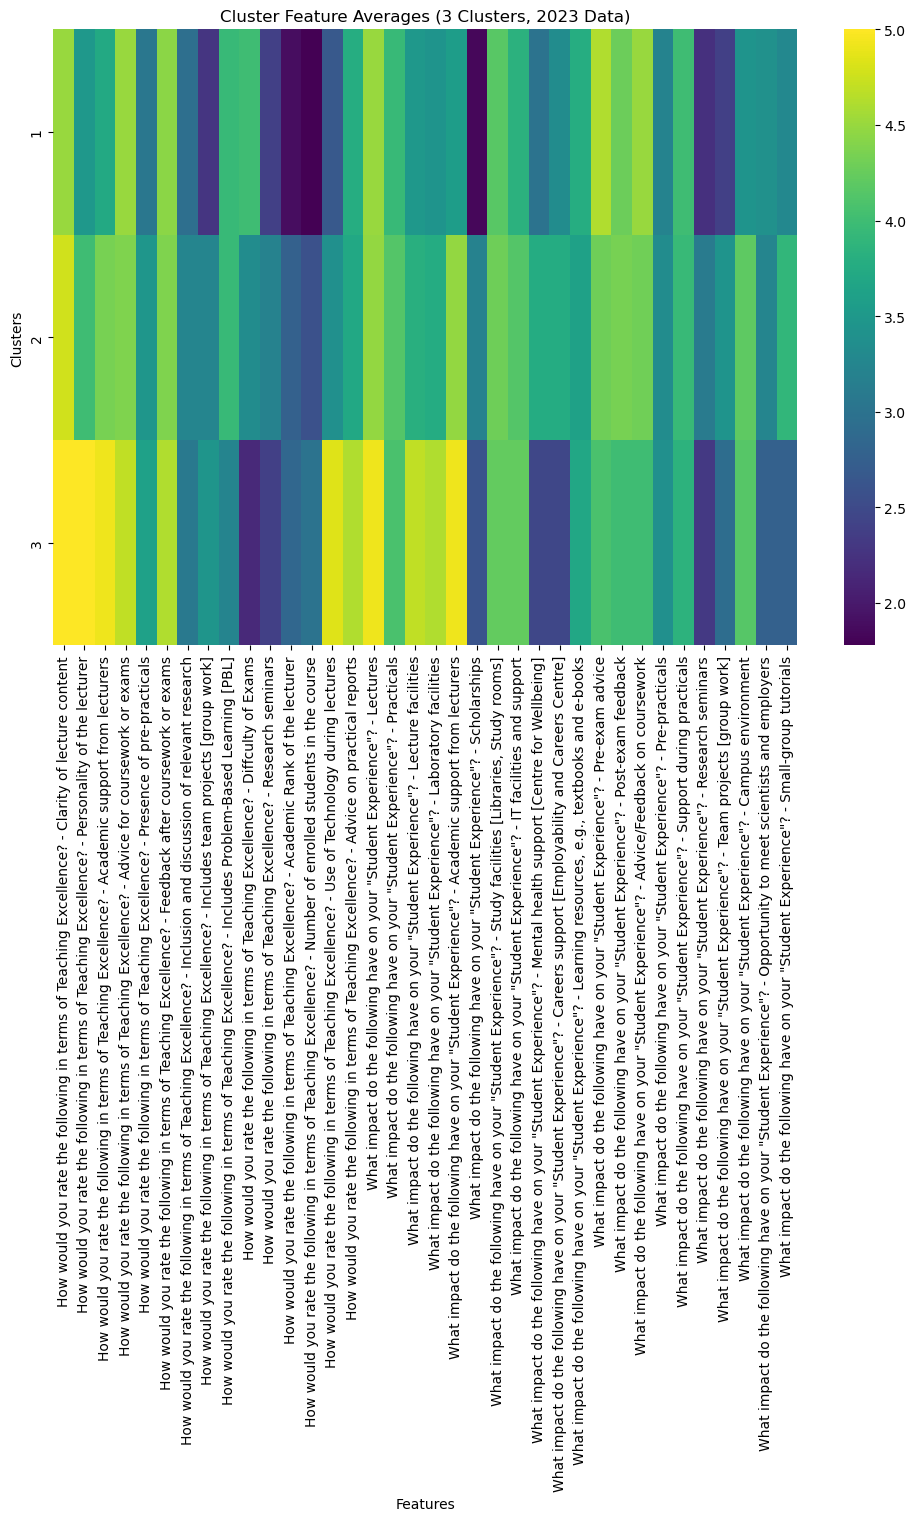

,How would you rate the following in terms of Teaching Excellence? - Clarity of lecture content,How would you rate the following in terms of Teaching Excellence? - Personality of the lecturer,How would you rate the following in terms of Teaching Excellence? - Academic support from lecturers,How would you rate the following in terms of Teaching Excellence? - Advice for coursework or exams,How would you rate the following in terms of Teaching Excellence? - Presence of pre-practicals,How would you rate the following in terms of Teaching Excellence? - Feedback after coursework or exams,How would you rate the following in terms of Teaching Excellence? - Inclusion and discussion of relevant research,How would you rate the following in terms of Teaching Excellence? - Includes team projects [group work],How would you rate the following in terms of Teaching Excellence? - Includes Problem-Based Learning [PBL],How would you rate the following in terms of Teaching Excellence? - Diffculty of Exams,...,"What impact do the following have on your ""Student Experience""? - Pre-exam advice","What impact do the following have on your ""Student Experience""? - Post-exam feedback","What impact do the following have on your ""Student Experience""? - Advice/Feedback on coursework","What impact do the following have on your ""Student Experience""? - Pre-practicals","What impact do the following have on your ""Student Experience""? - Support during practicals","What impact do the following have on your ""Student Experience""? - Research seminars","What impact do the following have on your ""Student Experience""? - Team projects [group work]","What impact do the following have on your ""Student Experience""? - Campus environment","What impact do the following have on your ""Student Experience""? - Opportunity to meet scientists and employers","What impact do the following have on your ""Student Experience""? - Small-group tutorials"
Cluster,,,,,,,,,,,,,,,,,,,,,
1,4.500000,3.5,3.722222,4.500000,3.055556,4.444444,2.944444,2.277778,3.944444,4.000000,...,4.611111,4.277778,4.5,3.222222,4.000000,2.222222,2.388889,3.444444,3.388889,3.277778
2,4.761905,4.0,4.333333,4.380952,3.476190,4.380952,3.238095,3.238095,3.952381,3.333333,...,4.285714,4.333333,4.3,3.333333,3.952381,3.105263,3.450000,4.200000,3.250000,3.900000
3,5.000000,5.0,4.923077,4.692308,3.615385,4.615385,3.076923,3.461538,3.230769,2.153846,...,4.076923,4.000000,4.0,3.384615,3.846154,2.307692,2.923077,4.153846,2.769231,2.769231


In [36]:
# Summarize clusters by calculating the mean of each feature
cluster_summary_2023 = data_2023_cleaned.groupby('Cluster').mean()

# Visualize the cluster summary as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_summary_2023, cmap="viridis", annot=False, cbar=True)
plt.title("Cluster Feature Averages (3 Clusters, 2023 Data)")
plt.xlabel("Features")
plt.ylabel("Clusters")
plt.show()

# Display the cluster summary for interpretation
cluster_summary_2023

In [32]:
# Verify the cluster distribution directly from the data
students_per_cluster_2023 = data_2023_cleaned['Cluster'].value_counts()

# Recalculate 1-based indices for students in each cluster
students_in_clusters_2023 = {
    cluster_id: (data_2023_cleaned[data_2023_cleaned['Cluster'] == cluster_id].index + 1).tolist()
    for cluster_id in range(1, 4)
}

students_per_cluster_2023, students_in_clusters_2023

(Cluster
 2    21
 1    18
 3    13
 Name: count, dtype: int64,
 {1: [4, 6, 11, 12, 30, 31, 33, 35, 36, 38, 41, 53, 55, 56, 60, 64, 65, 67],
  2: [5,
   7,
   9,
   10,
   14,
   40,
   46,
   47,
   49,
   50,
   51,
   54,
   57,
   58,
   59,
   61,
   62,
   63,
   68,
   69,
   76],
  3: [3, 8, 13, 20, 22, 23, 26, 28, 42, 43, 44, 45, 52]})